In [111]:
## Main SWR detection analysis! Note there are two ways to analyze the data: a cluster and local version. I keep them
## both updated with changes for now since I tend to check with the local version even if the cluster version is better
## for bulk analysis 2020-6-17 JS
## Updated for catFR1 analysis 2020-09-29 JS. Largely edited for manually removing bad electrodes 
## (search for catFR1 in CLUSTER get for example)

In [12]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

import seaborn as sb

df = get_data_index("r1") # all RAM subjects
exp = 'catFR1' # 'FR1' 'catFR1'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# sub lists I've been using to explore FR1 

subs = ['R1564J'] #'R1385E'] # ['R1065J'] #
# subs = ['R1002P','R1003P','R1006P','R1010J','R1112M','R1163T'] # initial 6 for hippocampus

# subs = subs+['R1001P','R1092J','R1151E','R1320D'] # additional subs with issues that I resolved with various RR and corr thresholds
# subs = ['R1112M','R1018P','R1020J','R1022J','R1023J','R1026D','R1027J'] # 7 with entorhinal
# subs = ['R1010J','R1112M'] # original 2 # R1108J beatiful catFR1 data; R1065J magical subject (like with FR1)
# subs = ['R1112M','R1163T'] # subjects with FR1 and catFR1. SRs of 1000 and 500 tho
# subs = ['R1151E'] # all channels X sessions get removed but 3 after 60/180 hz line removal
# these should all be worked out now. See SWR FR1 problem sessions PPT on Box for details of each
# subs = ['R1299T','R1332M','R1397D','R1349T','R1339D','R1337E','R1275D','R1151E','R1123C','R1120E','R1045E'] # final surrounding_recall problem subs after looking at huge raster!
# subs = ['R1308T','R1338T','R1358T'] # these guys had weird SRs and some loading problems when I went to whole_retrieval analysis...fixed with rounding
# subs = ['R1023J','R1101T','R1148P','R1368T','R1323T','R1334T'] # single session subs with memory allocation errors in ClusterRun
# subs = ['R1006P','R1010J','R1030J','R1032D','R1049J','R1051J','R1052E','R1054J','R1093J','R1098D','R1104D','R1108J','R1111M',
#         'R1115T','R1118N','R1124J','R1207J','R1230J','R1316T','R1329T','R1323T','R1337E','R1367D'] # subs that didn't load on 2020-07-04 encoding run
# subs = ['R1368T','R1461T','R1463E'] # subs with particularly low localization.pair matches in pairs...see Excel in loading info on Box for details
# subs = ['R1433E','R1355T','R1367D','R1368T'] # subs with "ca3" or "dg"
# subs = ['R1001P'] # subject with over 8000 FR1 trials X electrodes
# bad_subs = ['R1433E','R1051J'] # no electrode cats
# subs = ['R1379E','R1385E','R1387E','R1394E','R1402E'] # partial beep subs
# subs = ['R1379E','R1402E','R1396T','R1395M','R1415T','R1389J','R1404E']  # test subs for eeg offset correction

subs = ['R1054J','R1345D','R1048E','R1328E','R1308T', # first 2 are sr ≥ 1000. 3rd is 500 Hz.
        'R1137E','R1136N','R1122E','R1385E', # nice example FR1 subs used in Fig. 2
        'R1405E','R1486J','R1501J'] # adding in 3 catFR only patients that will go into Fig. 4

# subs = ['R1120E','R1349T','R1397D','R1332M','R1299T'] # FR1 patients with electrode search ranges limited per SWR problem sessions doc on Box
# subs = ['R1269E','R1328E','R1367D','R1397D','R1405E','R1405E','R1447M','R1469D'] # catFR1 patients with electrode search changes limited
# subs = ['R1094T']

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
# sub_df = sub_df[0:1]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
1710,NaN,protocols/r1/subjects/R1328E/experiments/catFR...,protocols/r1/subjects/R1328E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1328E/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1328E/localizations/0/m...,NaN,0,R1328E,R1328E,3.1,protocols/r1/subjects/R1328E/experiments/catFR...
1711,NaN,protocols/r1/subjects/R1328E/experiments/catFR...,protocols/r1/subjects/R1328E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1328E/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1328E/localizations/0/m...,NaN,2,R1328E,R1328E,3.1,protocols/r1/subjects/R1328E/experiments/catFR...
1712,NaN,protocols/r1/subjects/R1328E/experiments/catFR...,protocols/r1/subjects/R1328E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1328E/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1328E/localizations/0/m...,NaN,3,R1328E,R1328E,3.1,protocols/r1/subjects/R1328E/experiments/catFR...
1713,NaN,protocols/r1/subjects/R1328E/experiments/catFR...,protocols/r1/subjects/R1328E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1328E/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1328E/localizations/0/m...,NaN,4,R1328E,R1328E,3.1,protocols/r1/subjects/R1328E/experiments/catFR...
1909,NaN,protocols/r1/subjects/R1385E/experiments/catFR...,protocols/r1/subjects/R1385E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1385E/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1385E/localizations/0/m...,NaN,0,R1385E,R1385E,3.3,protocols/r1/subjects/R1385E/experiments/catFR...
1910,NaN,protocols/r1/subjects/R1385E/experiments/catFR...,protocols/r1/subjects/R1385E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1385E/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1385E/localizations/0/m...,NaN,1,R1385E,R1385E,3.3,protocols/r1/subjects/R1385E/experiments/catFR...
2011,NaN,protocols/r1/subjects/R1405E/experiments/catFR...,protocols/r1/subjects/R1405E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1405E/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1405E/localizations/0/m...,NaN,0,R1405E,R1405E,3.3,protocols/r1/subjects/R1405E/experiments/catFR...
2012,NaN,protocols/r1/subjects/R1405E/experiments/catFR...,protocols/r1/subjects/R1405E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1405E/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1405E/localizations/0/m...,NaN,1,R1405E,R1405E,3.3,protocols/r1/subjects/R1405E/experiments/catFR...
2013,NaN,protocols/r1/subjects/R1405E/experiments/catFR...,protocols/r1/subjects/R1405E/localizations/1/m...,catFR1,build,1,protocols/r1/subjects/R1405E/experiments/catFR...,1,NaN,NaN,protocols/r1/subjects/R1405E/localizations/1/m...,NaN,2,R1405E,R1405E_1,3.3,protocols/r1/subjects/R1405E/experiments/catFR...
2239,NaN,protocols/r1/subjects/R1486J/experiments/catFR...,protocols/r1/subjects/R1486J/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1486J/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1486J/localizations/0/m...,NaN,0,R1486J,R1486J,3.4,protocols/r1/subjects/R1486J/experiments/catFR...


In [3]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3))  # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
    #                 (df.subject!='R1065J') # sub with 9000 trials
                   ] 
elif exp == 'catFR1': 
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1501J') | (~df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
                    ]
elif exp == 'RepFR1':
    exp_df = exp_df[
                    (df.subject!='R1564J') # clearly something wrong with these EEG when looking at ripple raster
                    ]
exp_df.shape
# exp_df = exp_df[257:] # for catFR1 this is R1385E-onwwards
# exp_df = exp_df[472:] # for FR1 this is R1385E-onwwards
# exp_df = exp_df[-19:]
exp_df

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(503, 17)

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
24,NaN,protocols/r1/subjects/R1004D/experiments/catFR...,protocols/r1/subjects/R1004D/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1004D/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1004D/localizations/0/m...,NaN,0,R1004D,R1004D,NaN,protocols/r1/subjects/R1004D/experiments/catFR...
45,NaN,protocols/r1/subjects/R1013E/experiments/catFR...,protocols/r1/subjects/R1013E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1013E/experiments/catFR...,1,NaN,0,protocols/r1/subjects/R1013E/localizations/0/m...,NaN,0,R1013E,R1013E_1,NaN,protocols/r1/subjects/R1013E/experiments/catFR...
58,NaN,protocols/r1/subjects/R1015J/experiments/catFR...,protocols/r1/subjects/R1015J/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1015J/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1015J/localizations/0/m...,NaN,0,R1015J,R1015J,NaN,protocols/r1/subjects/R1015J/experiments/catFR...
64,NaN,protocols/r1/subjects/R1016M/experiments/catFR...,protocols/r1/subjects/R1016M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1016M/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1016M/localizations/0/m...,NaN,0,R1016M,R1016M,NaN,protocols/r1/subjects/R1016M/experiments/catFR...
65,NaN,protocols/r1/subjects/R1016M/experiments/catFR...,protocols/r1/subjects/R1016M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1016M/experiments/catFR...,0,NaN,1,protocols/r1/subjects/R1016M/localizations/0/m...,NaN,1,R1016M,R1016M,NaN,protocols/r1/subjects/R1016M/experiments/catFR...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,NaN,protocols/r1/subjects/R1541T/experiments/catFR...,protocols/r1/subjects/R1541T/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1541T/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1541T/localizations/0/m...,NaN,3,R1541T,R1541T,3.4,protocols/r1/subjects/R1541T/experiments/catFR...
2474,NaN,protocols/r1/subjects/R1541T/experiments/catFR...,protocols/r1/subjects/R1541T/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1541T/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1541T/localizations/0/m...,NaN,4,R1541T,R1541T,3.4,protocols/r1/subjects/R1541T/experiments/catFR...
2475,NaN,protocols/r1/subjects/R1541T/experiments/catFR...,protocols/r1/subjects/R1541T/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1541T/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1541T/localizations/0/m...,NaN,6,R1541T,R1541T,3.4,protocols/r1/subjects/R1541T/experiments/catFR...
2490,NaN,protocols/r1/subjects/R1542J/experiments/catFR...,protocols/r1/subjects/R1542J/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1542J/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1542J/localizations/0/m...,NaN,0,R1542J,R1542J,3.4,protocols/r1/subjects/R1542J/experiments/catFR...


## Load CLUSTER data

In [41]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used (note that exp is defined in first cell so can get exp_df above)

selected_period = 'encoding'
# 'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
# 'encoding': aligned to word_on

recall_type_switch = 0

recall_minimum = 0 # used if recall_type_switch = 3
region_name = 'PHC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC 
remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###
filter_type = 'hamming' # butter/hamming/hamming125200/tried hamming140250 for math
sub_selection = 'first_half' # 'second_half', 'whole' ,'first_half'
                              # analyze first 40%, remaining 60% of data, or whole? 
                              # works for FR1 and catFR1
###
%autoreload
# get strings for path name for save and loading cluster data
if recall_type_switch in [0,4,6,8]:
    # for these I'm using all trials, but selecting for which recall after the fact
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,0,selected_period,recall_minimum)
else: # these others I haven't set up indexing (see >line 100 in this cell)
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
ripple_array = []; 
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []; fr_array = []
list_num_key = []

serialpos_array = []; list_recall_num_array = []; # ~~~
rectime_array = []; recall_before_intrusion_array = []
recall_position_array = []; session_events = pd.DataFrame()

electrode_labels = []; channel_coords = []; channel_nums = []

analysis_df = getSplitDF(exp_df,sub_selection,exp)

for row in analysis_df.itertuples(): #analysis_df.itertuples(): #sub_df.itertuples():  #analysis_df.itertuples(): 
    try:
        sub = row.subject; session = row.session; exp = row.experiment

        path_name = '/scratch/john/SWR_scratch/'+subfolder
        
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                          '_'+soz_label+'_'+filter_type+'.p') #'_no_param_removal.p')   #'.p') #+'.intrusions.p') # +'.-wrong.p') (for wrong math)
        with open(fn,'rb') as f:
            dat = pickle.load(f)

            ripple_array = superVstack(ripple_array,dat['ripple_array']) 
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.extend(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            
#             # specific to whole_encoding
#             if selected_period == 'encoding':
#                 session_events = session_events.append(dat['session_events']) # doesn't append in place 

            serialpos_array.extend(dat['serialpos_array'])
            recall_position_array.extend(dat['recall_position_array'])   
            list_recall_num_array.extend(dat['list_recall_num_array'])
            
            electrode_labels.extend(dat['electrode_labels'])
            channel_coords.extend(dat['channel_coords'])
            channel_nums.extend(dat['channel_nums'])
            list_num_key.extend(dat['list_num_key'])
            
    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')  
print('**Done reading data**')
        
## loading *all* the recalls with 0, but if it's 4 or 6 load just those trials

# trying new method of loading...translate these to ripple_array length dependent on recall_type_switch 
# (this way I can always load from recall_type_switch = 0)

subject_name_array,session_name_array,electrode_array,channel_coords_array,channel_nums_array = getSubSessPredictorsWithChannelNums(
        sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords,channel_nums)
session_events['channel_num'] = channel_nums_array # append channels into the df

# spread out encoded_word_key too so I know which words were correct
word_correct_array = []
for sess_elec in encoded_word_key_array:
    word_correct_array.append(sess_elec)
word_correct_array = np.array(word_correct_array)
word_correct_array[word_correct_array>0] = 1 # 1s and 2s are corrects

# temp_recall_idxs = np.array(list_recall_num_array)>=0 # just keep them all
    
# subject_name_array = np.array(subject_name_array)[temp_recall_idxs]
# session_name_array = np.array(session_name_array)[temp_recall_idxs]
# electrode_array = np.array(electrode_array)[temp_recall_idxs]
# channel_coords_array = np.array(channel_coords_array)[temp_recall_idxs]
# channel_nums_array = np.array(channel_nums_array)[temp_recall_idxs]
# ripple_array = np.array(ripple_array)[temp_recall_idxs]
# rectime_array = np.array(rectime_array)[temp_recall_idxs]
# list_recall_num_array = np.array(list_recall_num_array)[temp_recall_idxs]
# recall_position_array = np.array(recall_position_array)[temp_recall_idxs]
    
print('**Done translating to ripple_array frame**!!')
print('...')
    
## some info on data loaded from cluster runs ##
ripple_array.shape

region_electrode_ct = np.array(region_electrode_ct)
# print('Number of electrodes in each session: '); region_electrode_ct
print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
print('Total trials: '+str(int(np.sum(trial_nums))))
print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')

# some info about regions 
sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))

print('Electrode regions X sessions:')
unique_names = np.unique(HPC_names)
for name in unique_names:
    num_elecs = sum(np.array([names.find(name) for names in HPC_names])>=0)
    print(str(num_elecs)+' for '+name)
    

['R1393T' 'R1461T' 'R1426N' 'R1269E' 'R1334T' 'R1239E' 'R1217T' 'R1303E'
 'R1264P' 'R1377M']
['R1386T' 'R1493T' 'R1278E' 'R1501J' 'R1477J' 'R1449T' 'R1243T' 'R1293P'
 'R1459M' 'R1496T']
2022-02-08_11-20-28: DF Exception: Sub: R1269E, Sess: 3, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/ENCODING/SWR_catFR1_R1269E_3_PHC_encoding_soz_in_hamming.p', file: <ipython-input-41-6c641e4459e7>, line no: 52
2022-02-08_11-20-29: DF Exception: Sub: R1426N, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/ENCODING/SWR_catFR1_R1426N_1_PHC_encoding_soz_in_hamming.p', file: <ipython-input-41-6c641e4459e7>, line no: 52
2022-02-08_11-20-29: DF Exception: Sub: R1459M, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/ENCODING/SWR_catFR1_R1459M_1_PHC_encoding_soz_in_hamming.p', file: <ipython-input-41-6c641e4459e7>, line no: 52
**Done reading data**
**Done translating to ripple_array f

(5328, 1500)

From 16/106 sessions with >0 PHC electrodes
Total trials: 5328
Unique sessions: 16
...from 8 patients
Number of electrodes: 14
Electrode regions X sessions:
8 for  right phg parahippocampal gyrus
20 for "phc"
2 for left phg parahippocampal gyrus
4 for right phc


In [42]:
# these should all be the same length!
len(ripple_array)
len(electrode_array)
len(list_num_key)
len(word_correct_array)
len(recall_position_array)
len(serialpos_array)
len(encoded_word_key_array)
len(session_name_array)

5328

5328

5328

5328

5328

5328

5328

5328

(5328, 1500)


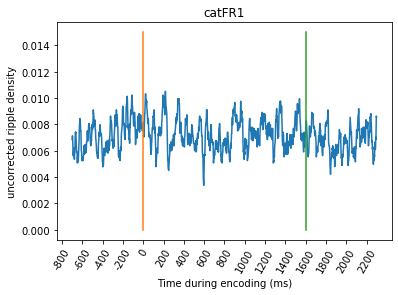

In [43]:
print(np.shape(ripple_array))
plot(np.mean(ripple_array,0))
if selected_period == 'whole_encoding':
    xticks(range(0,20000,2500),range(0,40000,5000))
    plot([1000,1000],[0,0.015])    
elif selected_period == 'encoding':
    xticks(ticks=range(-350,1501,100),labels=range(-1400,3001,200),rotation=60)
    plot([350,350],[0,0.015])
    plot([1150,1150],[0,0.015])   
elif selected_period == 'whole_retrieval':
    xticks(ticks=range(0,17001,2500),labels=range(0,32001,5000),rotation=60)
    plot([1000,1000],[0,0.015]) 
    plot([1000+15000,1000+15000],[0,0.015]) 
# ylim(0,0.015)
title(exp)
ylabel('uncorrected ripple density')
xlabel('Time during encoding (ms)');

## to visualize the removal parameters

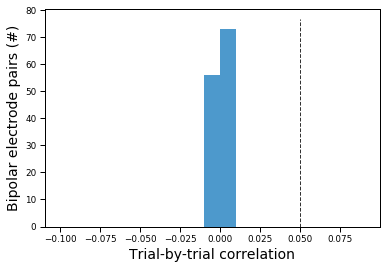

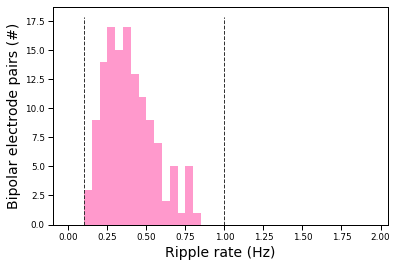

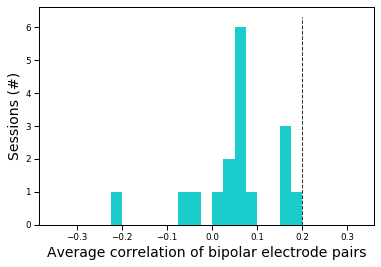

In [165]:
save_figs = 0
# np.array(trial_by_trial_correlation)
# np.array(elec_ripple_rate_array)
# np.array(elec_by_elec_correlation)
set_pubfig()

# trial-by-trial correlation
plt.hist(trial_by_trial_correlation,np.arange(-0.1,0.1,0.01),color = (0.3,0.6,0.8)); 
xlabel('Trial-by-trial correlation'); ylabel('Bipolar electrode pairs (#)'); 
plot([0.05,0.05],[gca().get_ylim()[0],gca().get_ylim()[1]],linewidth=1,linestyle='--',color=(0.2,0.2,0.2),label='_nolegend_')
if save_figs == 1:
    plt.savefig('../figures/control_params/trial-by-trial_correlation.pdf',transparent=True); show()
else:
    show()

# ripple rates
plt.hist(elec_ripple_rate_array,np.arange(0,2,0.05),color = (1,0.6,0.8)); 
xlabel('Ripple rate (Hz)'); ylabel('Bipolar electrode pairs (#)'); 
ylims = [gca().get_ylim()[0],gca().get_ylim()[1]]
plot([0.1,0.1],ylims,linewidth=1,linestyle='--',color=(0.2,0.2,0.2),label='_nolegend_')
plot([1,1],ylims,linewidth=1,linestyle='--',color=(0.2,0.2,0.2),label='_nolegend_')
if save_figs == 1:
    plt.savefig('../figures/control_params/ripple_rates_by_electrode.pdf',transparent=True); show()
else:
    show()
    
plt.hist(elec_by_elec_correlation,np.arange(-0.35,0.35,0.025),color = (0.1,0.8,0.8)); 
xlabel('Average correlation of bipolar electrode pairs'); ylabel('Sessions (#)'); 
plot([0.2,0.2],[gca().get_ylim()[0],gca().get_ylim()[1]],linewidth=1,linestyle='--',color=(0.2,0.2,0.2),label='_nolegend_')
if save_figs == 1:
    plt.savefig('../figures/control_params/sessions_electrode_correlations.pdf',transparent=True)
show();

#     max_ripple_rate = 3 #1.5 # Hz.
#     max_trial_by_trial_correlation = 1 #0.05 # if ripples correlated more than this remove them
#     max_electrode_by_electrode_correlation = 1 #0.2 #???
#     if filter_type == 'hamming':
#         min_ripple_rate = 0 # 0.1 # Hz.
#     else:
#         min_ripple_rate = 0.05 # for methods with lower rates decrease the minimum cutoff

## Get start_array and select subfield if HPC for free recalls

In [44]:
## DO YOU WANT TO SELECT A SUBFIELD or OUTPUT POSITION?? ##  

select_subfield = False   # note: if you already ran this once, have to load again from data
                          # also this is only for HPC. So set to False for ENT and PHC
    
# select for subfield if HPC
if select_subfield == True:
    location_selected = 'dg' #'dg' # 'ca3' # 'dg' 'ca1' # sub # ['ca1','dg']
        # left # right # left hippocampus # right hippocampus # hippocampus
        # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
else:
    location_selected = ''
    

### Use a task condition to select recalls?? ###
### ...will select first one that's not 0    ###
select_ordinal_position = 0              # select only recalls at given output position. 0 means it's off ##DEPRECATED
select_list_position = 0 #[1,2,3] #[12]  # select only recalls at given position from encoding list. 
                                         # 0 means it's off. Must be list
select_less_than_rectime = 0             # select only recalls < this number % 5000
select_greater_than_rectime = 0          # select only recalls ≥ this number % 5000
select_lists_with_recalls = 0 # list(np.arange(3,13)) # [1] so this would select ≥4 recalls. Must be list hence the list(arange...)
                                         # select only recalls that come from lists with number in this list
select_intrusions_next = 0               # select recalls that lead to intrusions
    
if filter_type.find('hamming') != -1:
    desired_sample_rate = 500.
else:
    desired_sample_rate = 1000.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums[0:20])
print('Trial sum = '+str(np.sum(trial_nums)))
print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))


start_array,end_array = getStartEndArrays(ripple_array); print('Got encoding start_array!')
 
# if selected an output position
if select_ordinal_position > 0:
    if np.min(ordinal_position_array) == 0: # only update this once (so don't have to reload data from files)
        ordinal_position_array = np.array(ordinal_position_array)+1 # now 1-indexed
    selected_recalls = ordinal_position_array==select_ordinal_position
elif type(select_list_position) == list:
    selected_recalls = [sp in select_list_position for sp in serialpos_array]
elif select_intrusions_next == 1:
    selected_recalls = np.array(recall_before_intrusion_array)==True
elif select_less_than_rectime > 0:
    selected_recalls = np.array(rectime_array)<select_less_than_rectime
elif select_greater_than_rectime > 0:
    selected_recalls = np.array(rectime_array)>=select_greater_than_rectime
elif type(select_lists_with_recalls) == list:
    selected_recalls = [recall in select_lists_with_recalls for recall in list_recall_num_array]
else:
    selected_recalls = np.ones(len(start_array),dtype=bool)
    
# get locations if selected

if select_subfield == True:
    # create the full vector of location name predictors
    location_names = []
    for s in range(len(HPC_names)):
        new_trials = int(trial_nums[s])
        location_names.extend(np.tile(HPC_names[s],new_trials))  
        
    # now can get mask of trials in this location
    
    #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
    location_mask = np.zeros(len(location_names))
    for s in range(len(location_names)):
        if type(location_selected)==list:
            if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                location_mask[s] = True
        elif type(location_selected)==str:
            if location_names[s].find(location_selected)>=0:
                location_mask[s] = True
else:
    location_mask = np.ones(len(start_array))

# DON'T USE temp_recall_idxs FOR ENCODING
# # gotta translate this to new frame as well from idxs in load step if selected subfield
# if select_subfield == True: 
#     location_mask = location_mask[temp_recall_idxs] 

# combine location and sorted recalls to get new ripple array:
updated_recalls = (location_mask+selected_recalls)==2

# this one list did not have 27 word presentations, so remove it
if exp == 'RepFR1':
    updated_recalls[(np.array(session_name_array)=='R1579T-1') & (np.array(list_num_key)==16)] = 0
    
# translate these predictors to vector and select recalls
start_array = start_array[updated_recalls]
end_array = end_array[updated_recalls] # used for duration calculations
subject_name_array = np.array(subject_name_array)[updated_recalls]
session_name_array = np.array(session_name_array)[updated_recalls]
electrode_array = np.array(electrode_array)[updated_recalls]
channel_coords_array = np.array(channel_coords_array)[updated_recalls]
channel_nums_array = np.array(channel_nums_array)[updated_recalls]
if selected_period in ['surrounding_recall','math','math_retrieval','whole_encoding','whole_retrieval']:
    list_recall_num_array = np.array(list_recall_num_array)[updated_recalls] # for subject-level analysis
# rectime_array = np.array(rectime_array)[updated_recalls]
# recall_position_array = np.array(recall_position_array)[updated_recalls]

# specific to encoding
# serialpos_array = np.array(serialpos_array)[updated_recalls] # FIX THIS ONCE RUN AGAIN 2021-09-16
# list_recall_num_array = np.array(list_recall_num_array)[updated_recalls]

# if selected_period in ['encoding','whole_encoding']:
encoded_word_key_array = np.array(encoded_word_key_array)[updated_recalls]
serialpos_array = np.array(serialpos_array)[updated_recalls]
list_num_key = np.array(list_num_key)[updated_recalls]
word_correct_array = word_correct_array[updated_recalls]
recall_position_array = np.array(recall_position_array)[updated_recalls]
# if selected_period == 'encoding':    
#     session_events = session_events[updated_recalls]
    
print('Got start_array with '+str(start_array.shape[0])+' trials!')

sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')
        
# # plot whole retrieval period with FR events superimposed on SWRs
# if selected_period == 'whole_bretrieval':
#     start_array2 = start_array # for whole retrieval period
#     print('Base SWRs/30 s retrieval: '+str(sum(start_array2)/start_array2.shape[0]/(30000/1000)))
#     ## can go straight to "SWRs by time in retrieval period" from here
# else:
#     print('SWRs rate in 4 s around FR: '+str(sum(start_array)/start_array.shape[0]/(4000/1000)))

# # subplots(1,1,figsize=(6,9))
# # plot([0,0],[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # plot(np.ones(2)*(retrieval_whole_time),[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # scatter(np.where(start_array2)[1]*sr_factor+psth_start,np.where(start_array2)[0],s=0.5)
# # scatter(np.where(fr_array)[1],np.where(fr_array)[0],s=0.5,color=[1,0,0]); 
# # plt.xlabel('Retrieval period time (ms)')
# # plt.ylabel('Retrieval period')
# # if save_plot == 1:
# #     plt.savefig('../plots/'+'SWR_FR_'+region_name+'-'+str(session_ct)+'_sessions_in-'+str(sub_num)+'subjects_'+filter_type+'.pdf',transparent=True)
# # plt.show();    

print('# of trials: '+str(np.shape(start_array)[0]))
print('Total # of ripples: '+str(sum(start_array)))
print('Overall ripple rate: '+str(np.round( (1000/sr_factor)*sum(start_array)/np.shape(start_array)[0]/np.shape(start_array)[1],3 ))+' Hz')

Total electrodes loaded: 34
from 16 sessions from 8 subjects with trial nums:
[300. 300. 120. 120. 240. 300.  60.  60. 132. 132. 180. 180. 180. 144.
 144. 144. 144. 144. 144. 144.]
Trial sum = 5328.0
['right phc', 'right phc', 'right phc', 'right phc', 'left phg parahippocampal gyrus', 'left phg parahippocampal gyrus', ' right phg parahippocampal gyrus', ' right phg parahippocampal gyrus', ' right phg parahippocampal gyrus', ' right phg parahippocampal gyrus', ' right phg parahippocampal gyrus', ' right phg parahippocampal gyrus', ' right phg parahippocampal gyrus', '"phc"', ' right phg parahippocampal gyrus', '"phc"', '"phc"', '"phc"', '"phc"', '"phc"']
Number of sub_sess names: 34
Got encoding start_array!
Got start_array with 5328 trials!
Number of electrodes: 14
...from 8 patients
# of trials: 5328
Total # of ripples: 3848
Overall ripple rate: 0.241 Hz


# Subject-level memory performance

In [116]:
# do subjects show a bigger ripple bump when they remember more words/list?

## NOTE: to run this make sure:
## 1) recall_select_type = 6. HAVE to remove first recalls of each list or will bias result since
##    first recall doesn't have bump anyway and worse performing patients will have more first recalls.
##    selecting for ≥2 recalls takes all trials that should have bumps and compares those
## 2) selected_recalls from last cell gives all trials (it'll crash otherwise due to indexing error)
## 3) for high v. low memory analysis, need to comment out bin_model2, 

# goal is ot measure z-scores of each individual subject and also correlate those to temporal clustering

min_trials = 20 # define up here since use for ME model arrays being appended too

import statsmodels.formula.api as smf
import warnings
%autoreload

sub_Ts1 = []
sub_Bs1 = [] 

trial_accum = []; trial_accum_correct = []
sub_z_score = []
rate_accum = []; rate_accum_correct = []; rate_accum_wrong = []
trial_ct = 0
temp_sub_names = []
sub_avg_recall_num = []; sub_avg_recall_time = []

ME_bin = []; ME_recall_num = []
ME_sessions = []; ME_subjects = []


for sub in np.unique(subject_name_array):
    sub_idxs = [sub in s for s in subject_name_array]
    if sum(sub_idxs) > 1:
        sub_start_array = start_array[sub_idxs]
        sub_subject_name_array = np.array(subject_name_array)[sub_idxs]
        sub_session_name_array = np.array(session_name_array)[sub_idxs]
        sub_word_correct_array = np.array(word_correct_array)[sub_idxs]
        sub_electrode_array = np.array(electrode_array)[sub_idxs]
        sub_recall_position_array = np.array(recall_position_array)[sub_idxs]
       
        # now get z-score separately for each sub with ME model

        # measure significance from 
        ripple_bin_start_end = [100,1300]
        stats_bin = ripple_bin_start_end[1]-ripple_bin_start_end[0] # only using 1 bin for encoding        
        psth_start = -700 # setting in SWRanalysis for pre_encoding_time

        binned_stats_array = sub_start_array[:,int((ripple_bin_start_end[0]-psth_start)/sr_factor):
                                               int((ripple_bin_start_end[1]-psth_start)/sr_factor)]
        binned_stats_array = binBinaryArray(binned_stats_array,stats_bin,sr_factor)
        
        if len(binned_stats_array) >= min_trials:
            
            # what is this patient's average accuracy?
            session_avg_corr = []
            for sess in np.unique(sub_session_name_array):
                # take 1st elec every session so don't double count sessions
                if sess == 'R1334T-2':
                    first_elec = np.unique(sub_electrode_array)[1] # montage must have changed with this one
                else:
                    first_elec = np.unique(sub_electrode_array)[0]
                session_recalls = sub_recall_position_array[((sub_session_name_array==sess) & \
                                                         (sub_electrode_array==first_elec))]# this is a list of lists for accuracy in this session
                session_avg_corr.append(np.nanmean([len(x) for x in session_recalls])) # mean correct for this session

            sub_avg_recall_num.append(np.nanmean(session_avg_corr)) # average over sessions for final accuracy value
            temp_sub_names.append(sub)

            rate_accum.append(np.mean(binned_stats_array))
            rate_accum_correct.append(np.mean(binned_stats_array[sub_word_correct_array==1]))
            rate_accum_wrong.append(np.mean(binned_stats_array[sub_word_correct_array==0]))            
            trial_accum.append(len(binned_stats_array))
            trial_accum_correct.append(sum(sub_word_correct_array))
            trial_ct+=len(binned_stats_array)

            if np.mod(len(temp_sub_names),10)==0:
                print('done binning start_arrays (printing every 10th)'); len(binned_stats_array)
                print(str(np.mean(binned_stats_array))+' for '+str(len(binned_stats_array))+ ' trials')
                print(trial_ct)

            # create data arrays for mixed effects model of bump v. memory after plots in next cell
            ME_bin.extend(binned_stats_array)
            ME_recall_num.extend(sub_avg_recall_num[-1]*np.ones(len(binned_stats_array)))
            ME_sessions.extend(sub_session_name_array)
            ME_subjects.extend(sub_subject_name_array)

            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                
                # model for each sub to assess significance of SME
                sub_SME_df = pd.DataFrame(data={'session':sub_session_name_array,'subject':sub_subject_name_array,
                               'correct':sub_word_correct_array,'ripple_rates':binned_stats_array[:,0]})
                vc = {'session':'0+session'}
                sig_bin_model = smf.mixedlm("ripple_rates ~ correct", sub_SME_df, groups="subject", vc_formula=vc)
                bin_model = sig_bin_model.fit(reml=True, method='nm',maxiter=2000)

                sub_Ts1.append(bin_model.tvalues[1])
                sub_Bs1.append(bin_model.params[1])

# corrected_for_nans = 0 # for below
a=1;

done binning start_arrays (printing every 10th)
0.26300236406619387 for 564 trials
14364
done binning start_arrays (printing every 10th)
0.5497685185185186 for 288 trials
27777


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


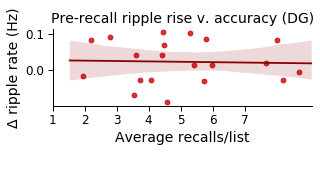

Max is 4.95, Min is -3.06
Number of low recall patients: 10
Number of high recall patients: 10
T-test between these: p = 0.6656436637575346
T-test between t-stats for each group instead: p = 0.6083942278058978
t-statistic: -0.5214734167647864


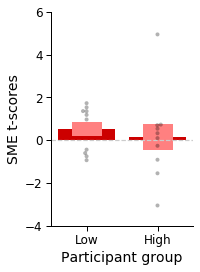

Number of participants in plot: 20


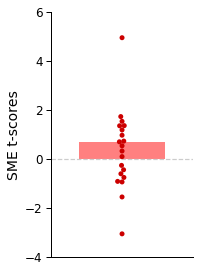

One-sample t-test of t-scores: 0.35181278962033735
t-statistic: 0.9545101777607634
Number of participants in plot: 20


/home1/john/johnModules/general.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  second_test = num == 'nan' # some string types don't work with above line


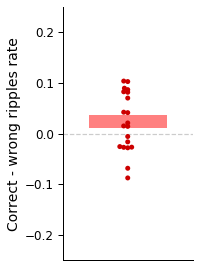

In [117]:
save_figs = 0

import seaborn as sb
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
    
def defaultPlotting(): 
    sb.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")

if location_selected == 'dg':
    min_rate = 0.1
    plot_color = [(0.8,0,0)]
    lmplot_color = (0.8,0,0,0)
    errorbar_color = (1,0.5,0.5)
    line_color = 'darkred'
elif region_name == 'ENT':
    min_rate = 0.0 # for ENT and PHC I don't do further stats so just set to 0 to show all the datapoints in the swarm
    plot_color = [(0.5,0.5,0)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0.8,0.8,0)
    line_color = 'black'
elif region_name == 'PHC':
    min_rate = 0.0
    plot_color = [(0,0.5,0.5)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0,0.8,0.8)
    line_color = 'black' 
elif location_selected == 'ca1' or location_selected == '':
    min_rate = 0.1 # for CA1 and DG I require a FR minimum for the two bins being compared since I do further stats on them
    plot_color = [(0,0,0.8)]
    lmplot_color = (0,0,0.8,0)
    errorbar_color = (0.5,0.5,1)
    line_color = 'darkblue'
    
min_correct_trials = 50

# only keep subs with sufficient trials and ripple rates
good_subs = ((np.array(trial_accum_correct)>=min_correct_trials)&(np.array(rate_accum) > min_rate))
rate_accum = np.array(rate_accum)[good_subs]  
rate_accum_correct = np.array(rate_accum_correct)[good_subs]
rate_accum_wrong = np.array(rate_accum_wrong)[good_subs]
sub_Ts1 = np.array(sub_Ts1)[good_subs]    
trial_accum = np.array(trial_accum)[good_subs]    
temp_sub_names = np.array(temp_sub_names)[good_subs]        
sub_avg_recall_num = np.array(sub_avg_recall_num)[good_subs]    


### $$$# subject-level figures we decided on ##$$###$

   
    
## Ripple rate delta between key bin and 1 sec before bin v. temporal clutsering

rate_accum_delta = np.array(rate_accum_correct) - np.array(rate_accum_wrong)

set_pubfig()
plot_df4 = pd.DataFrame({'avg_recall_num':sub_avg_recall_num,'ripple_rates':rate_accum_delta,
                        'sub_Ts1':sub_Ts1})
sb.lmplot(x='avg_recall_num',y='ripple_rates',data=plot_df4,
         scatter_kws = {'color': lmplot_color},line_kws = {'color': line_color},
         size=4,aspect=1.25)

# gca().set(ylim=(0,0.85),xlim=(1.5,5.5))
gca().tick_params(labelsize=12)
# gca().set(xlim=(2,5))
plot_corr = np.corrcoef(sub_avg_recall_num,rate_accum_delta)[0][1]
annotate('Correlation: '+str(np.round(plot_corr,3)),(3.5,-0.25))
ylabel(u'Δ ripple rate (Hz)')
xlabel('Average recalls/list')
if type(location_selected)==list:
    location_selected = location_selected[0]+location_selected[1]
title('Pre-recall ripple rise v. accuracy ('+location_selected.upper()+')')
xticks(np.arange(1,7.01,1))
gcf().tight_layout()

if save_figs == 1:
    fname = '/home1/john/SWR/figures/subject-level_plots/deltaRRvMemory_'+exp+'_'+region_name+'_'+\
        location_selected+'_encoding_'+'_'+filter_type+'_'+sub_selection+'.pdf'
    savefig(fname,format='pdf',transparent=True)
save_fig = 0
show()


## high v. low recall patients

split_into = 2 # high v. low
delta_ripple_or_Ts = 1 # 0 for delta_ripples; 1 for sub_Ts

set_pubfig()
plot_df = copy(plot_df4) # plot_df4 is delta(rate) # plot_df5 is PRE bin
quartile_labels = range(split_into)
quartiles = pd.qcut(plot_df.avg_recall_num,split_into,labels=quartile_labels)
quartile_idxs = np.array(quartiles.values)
mean_ripples = []; ste_ripples = []
mean_mem = []; ste_mem = []
for val in np.unique(quartile_idxs):
    selected_quartile = quartile_idxs==val
    if delta_ripple_or_Ts == 0:
        mean_ripples.append(np.mean(plot_df.ripple_rates[selected_quartile]))
        ste_ripples.append(np.std(plot_df.ripple_rates[selected_quartile])/np.sqrt(len(plot_df.ripple_rates[selected_quartile])))
    else:
        mean_ripples.append(np.mean(plot_df.sub_Ts1[selected_quartile]))
        ste_ripples.append(np.std(plot_df.sub_Ts1[selected_quartile])/np.sqrt(len(plot_df.sub_Ts1[selected_quartile])))        
plot_df['idxs'] = quartile_idxs # for swarmplot

figSub,axSub = plt.subplots(1,1, figsize=(3,4))
# axSub.bar(range(split_into),mean_ripples,yerr=ste_ripples,color=plot_color)
bar(range(split_into),mean_ripples,yerr=ste_ripples,color=plot_color,error_kw=dict(lw=30, capsize=0, capthick=0, ecolor=errorbar_color))
gca().axhline(0, ls='--',color=(0.8,0.8,0.8))

# changes from Mike
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)

add_swarm = 1
if add_swarm == 1:
    extra = '_swarm'
    if delta_ripple_or_Ts == 0:
        sb.swarmplot(x='idxs',y='ripple_rates',data=plot_df, ax=axSub, color=(0,0,0), alpha=0.3, size=4)
        axSub.set(ylim=(-0.5,0.5))
        ytick_range = np.arange(-0.5,0.501,0.25)
        ylabel(u'Δ ripple rate (Hz)')
    else:
        sb.swarmplot(x='idxs',y='sub_Ts1',data=plot_df, ax=axSub, color=(0,0,0), alpha=0.3, size=4)
        axSub.set(ylim=(-4,6))
        ytick_range = np.arange(-4,6.01,2)        
        ylabel(u'SME t-scores')
else:
    ylim(0,0.175)
    ytick_range = np.arange(0,0.151,0.05)
    extra = ''
    
yticks(ytick_range,fontsize=12)
xticks([0,1],['Low','High'],fontsize=12) # somehow these are reversed but the high patients have high ripples (see the means below)]
xlabel('Participant group')
print('Max is '+str(np.round(max(plot_df.sub_Ts1),2))+', Min is '+str(np.round(min(plot_df.sub_Ts1),2)))



print('Number of low recall patients: '+str(sum(np.array(quartiles.values))))
print('Number of high recall patients: '+str(sum(np.array(quartiles.values)==0)))
print('T-test between these: p = '+
    str(ttest_ind(plot_df.ripple_rates[np.array(quartiles.values)==1], plot_df.ripple_rates[np.array(quartiles.values)==0])[1]))
print('T-test between t-stats for each group instead: p = '+
    str(ttest_ind(plot_df.sub_Ts1[np.array(quartiles.values)==1], plot_df.sub_Ts1[np.array(quartiles.values)==0])[1]))
print('t-statistic: '+str(ttest_ind(plot_df.sub_Ts1[np.array(quartiles.values)==1], plot_df.sub_Ts1[np.array(quartiles.values)==0])[0]))
np.mean(plot_df.ripple_rates[np.array(quartiles.values)==1]) # high ripple rate patients
np.mean(plot_df.ripple_rates[np.array(quartiles.values)==0])
np.mean(plot_df.avg_recall_num[np.array(quartiles.values)==1]) # high memory patients
np.mean(plot_df.avg_recall_num[np.array(quartiles.values)==0])

tight_layout()
if save_figs == 1:
    fname = '/home1/john/SWR/figures/subject-level_plots/low_v_high_memory_'+exp+'_'+region_name+'_'+\
        location_selected+'_encoding_'+filter_type+'_'+sub_selection+extra+'.pdf'
    savefig(fname,format='pdf',transparent=True)
save_fig = 0
show()


# t-score histogram (PRE)

# (doing this at end since I ensure PRE bin and bin 1 sec earlier have > 0.1 hz RRs) 

set_pubfig()
temp_df = pd.DataFrame({'sub_Ts':sub_Ts1,'ripple_delta':rate_accum_delta})
if region_name == 'HPC':
    fig, ax = subplots(figsize=(3,4))
else:
    fig, ax = subplots(figsize=(3,3))

# first plot the error bars
st_err = np.std(sub_Ts1)/np.sqrt(len(sub_Ts1))
bar_bottom = np.mean(sub_Ts1)-st_err
bar_height = 2*st_err
bar(x=0,height=bar_height,width=0.6,bottom=bar_bottom,color=errorbar_color)

# changes from Mike
yticks(fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# now the swarm
p1 = sb.swarmplot(ax=ax,y='sub_Ts', data=temp_df, palette=plot_color) 
# ax1 = p1.axes
ax.axhline(0, ls='--',color=(0.8,0.8,0.8))
ax.set(xticks=[])
ax.tick_params(labelsize=12)
if region_name == 'HPC':
    if selected_period == 'surrounding_recall':
        ax.set(ylim=(-3.25,6.25))
    else:
        ax.set(ylim=(-4,6))
        ytick_range = np.arange(-4,6.01,2)
else:
    ax.set(ylim=(-3.25,4.25))
yticks(ytick_range,fontsize=12)
ylabel('SME t-scores')
tight_layout()
print('Number of participants in plot: '+str(len(sub_Ts1)))

if save_figs == 1:
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    fname = '/home1/john/SWR/figures/subject-level_plots/t-score_histo_'+exp+'_'+region_name+'_'+\
        location_selected+'_encoding_'+'_'+filter_type+'_'+sub_selection+'.pdf'
    savefig(fname,format='pdf',transparent=True)
save_fig = 0
show()
# print sign test across subjects too
test_sub_Ts1 = sub_Ts1[~isNaN(sub_Ts1)]
t_stat,onesample_p = stats.ttest_1samp(test_sub_Ts1,0)
print('One-sample t-test of t-scores: '+str(onesample_p))
print('t-statistic: '+str(t_stat))


# delta ripple rate

set_pubfig()
temp_df = pd.DataFrame({'sub_Ts':sub_Ts1,'ripple_delta':rate_accum_delta})
fig, ax = subplots(figsize=(3,4))

# first plot the error bars
st_err = np.std(rate_accum_delta)/np.sqrt(len(rate_accum_delta))
bar_bottom = np.mean(rate_accum_delta)-st_err
bar_height = 2*st_err
bar(x=0,height=bar_height,width=0.6,bottom=bar_bottom,color=errorbar_color)

# changes from Mike
yticks(fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# now the swarm
p1 = sb.swarmplot(ax=ax,y='ripple_delta', data=temp_df, palette=plot_color) 
ax.axhline(0, ls='--',color=(0.8,0.8,0.8))
ax.set(xticks=[])
ax.tick_params(labelsize=12)
ax.set(ylim=(-0.25,0.25))

ylabel('Correct - wrong ripples rate')
tight_layout()
print('Number of participants in plot: '+str(len(rate_accum_delta)))


##$$$ ###

a=1;

# RepFR1: Analyze the effect of repeated word presentation on the rise in ripples

In [230]:
%autoreload

select_category_repeat = 0 # 1, 2, 3, 0 # 0 means use all categories. 1:3 mean select only 1st, 2nd, 3rd usage of category

encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700
ripple_bin_start_end = [300,1300] # range I'm going to look for ripples for regression of serialpos and category predictors

# first, get array that indicates which of 3 presentations each of these words is within list
presentation_array = getRepFRPresentationArray(session_name_array,list_num_key,session_events)  

# identity of 1p, 2p, or 3p words
repeat_array = getRepFRRepeatArray(session_name_array,list_num_key,session_events)


In [168]:
# confirm these three arrays are the same size
len(session_events)
len(repeat_array)
len(presentation_array)

# print some examples for manual checks
np.array(session_events.item_name[0:27])
np.array(session_events.item_name[27:54])
repeat_array[0:35] # 1p, 2p, or 3p
np.array(session_events.repeats.values)[0:35]
presentation_array[0:35] # which of the Xp is it? E.g. for 3p could be 1, 2, or 3
list_num_key[0:54]

np.array(session_events.item_name.iloc[34:40])
repeat_array[34:40]
np.array(session_events.repeats.values)[34:40]
presentation_array[34:40]

71712

NameError: name 'repeat_array' is not defined

done making binned start_array with shape:
(8220, 26)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_lin

SEs created!
done making binned start_array with shape:
(16440, 26)
done making binned start_array with shape:
(49320, 26)
SEs created!


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


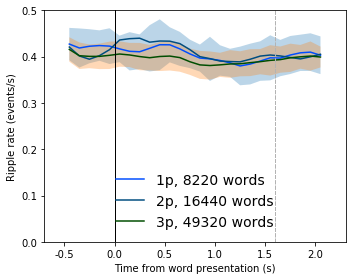

In [264]:
# Plot for 1p, 2p, and 3p words

%autoreload

# Then bin it for the CIs and plot each
# then do ME stats on seleted bins and add significance bars if p<0.05

plot_SEs = 1

bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?
sr_factor = 2

# for 1p to 3p
for category in range(1,4):

    temp_start_array = start_array[repeat_array==category]
    temp_subject_name_array = subject_name_array[repeat_array==category]
    temp_session_name_array = session_name_array[repeat_array==category]
        
    if category == 1:
        # for plot
        subplots(1,1,figsize=(5,4))        
        plot_color = (0,0.3,1) #(1,0,0)
        label = '1p, '+str(len(temp_start_array))+' words'
#         text(500,0.21,label,usetex=True,size=16,color=plot_color)
#         text(500,0.18,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)

    elif category == 2:       
        label = '2p, '+str(len(temp_start_array))+' words'  
        plot_color = (0,0.3,0.5) #(0.75,0,0)
    elif category == 3:       
        label = '3p, ' +str(len(temp_start_array))+' words'  
        plot_color = (0,0.3,0.0) # (0.5,0,0)
        
    # make a PSTH based on start times of SWRs

    PSTH,bin_centers = fullPSTH(temp_start_array,bin_size,smoothing_triangle,sr,pre_encoding_time)
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
#     boot_samples = bootstrap(temp_start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
#                    bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,pre_encoding_time))
#     boot_SD = np.std(boot_samples,0)

    # get binned start array (trials X bins)
    binned_start_array = binBinaryArray(temp_start_array,bin_size,sr_factor)
    if pad > 0:
        binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
    print('done making binned start_array with shape:')
    print(binned_start_array.shape)

    # note that output is the net ± distance from mean

    if (plot_SEs == 1) & (category in [1,3]):
        SE_plot = getMixedEffectSEs(binned_start_array,temp_subject_name_array,temp_session_name_array)
        print('SEs created!')
    
    # plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    xr = xr[pad:-pad]; 
    
    plot(xr,PSTH[pad:-pad],color=plot_color,label = label)
    
    if (plot_SEs == 1) & (category in [1,3]):
        fill_between(xr, PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)')
    ylabel('Ripple rate (events/s)')
    tight_layout()
    ax = plt.gca()
    ylim = 0.5
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time,encoding_time)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))
    

leg = ax.legend(frameon=False,prop={'size': 14},loc='lower center')
a=1;

done making binned start_array with shape:
(16440, 26)
SEs created!
done making binned start_array with shape:
(16440, 26)
done making binned start_array with shape:
(16440, 26)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_lin

SEs created!


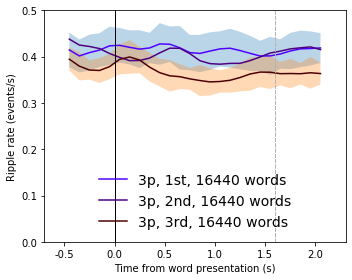

done making binned start_array with shape:
(8220, 26)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


SEs created!
done making binned start_array with shape:
(8220, 26)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


SEs created!


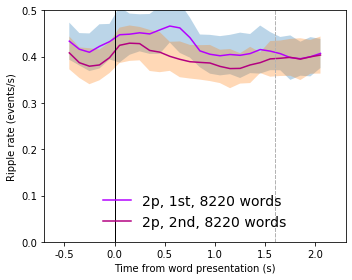

In [263]:
# Plot 1st-2nd for 2p and 1st-3rd pres for 3p 

%autoreload

# Then bin it for the CIs and plot each
# then do ME stats on seleted bins and add significance bars if p<0.05

plot_SEs = 1

bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?
sr_factor = 2

# 3p then 2p
for category in range(1,6):
        
    if category == 1:
        # for plot
        subplots(1,1,figsize=(5,4))        
        temp_start_array = start_array[(presentation_array==1) & (repeat_array==3)]
        temp_subject_name_array = subject_name_array[(presentation_array==1) & (repeat_array==3)]
        temp_session_name_array = session_name_array[(presentation_array==1) & (repeat_array==3)] 
        plot_color = (0.3,0,1) 
        label = '3p, 1st, ' +str(len(temp_start_array))+' words'  
    elif category == 2:       
        temp_start_array = start_array[(presentation_array==2) & (repeat_array==3)]
        temp_subject_name_array = subject_name_array[(presentation_array==2) & (repeat_array==3)]
        temp_session_name_array = session_name_array[(presentation_array==2) & (repeat_array==3)]        
        plot_color = (0.3,0,0.5) 
        label = '3p, 2nd, ' +str(len(temp_start_array))+' words'         
    elif category == 3:       
        temp_start_array = start_array[(presentation_array==3) & (repeat_array==3)]
        temp_subject_name_array = subject_name_array[(presentation_array==3) & (repeat_array==3)]
        temp_session_name_array = session_name_array[(presentation_array==3) & (repeat_array==3)]        
        plot_color = (0.3,0,0) 
        label = '3p, 3rd, ' +str(len(temp_start_array))+' words'
    elif category == 4:
        # for plot
        subplots(1,1,figsize=(5,4))        
        temp_start_array = start_array[(presentation_array==1) & (repeat_array==2)]
        temp_subject_name_array = subject_name_array[(presentation_array==1) & (repeat_array==2)]
        temp_session_name_array = session_name_array[(presentation_array==1) & (repeat_array==2)]          
        plot_color = (0.7,0,1) 
        label = '2p, 1st, ' +str(len(temp_start_array))+' words'         
    elif category == 5:
        temp_start_array = start_array[(presentation_array==2) & (repeat_array==2)]
        temp_subject_name_array = subject_name_array[(presentation_array==2) & (repeat_array==2)]
        temp_session_name_array = session_name_array[(presentation_array==2) & (repeat_array==2)]    
        plot_color = (0.7,0,0.5) 
        label = '2p, 2nd, ' +str(len(temp_start_array))+' words'         
        
    # make a PSTH based on start times of SWRs                                                     

    PSTH,bin_centers = fullPSTH(temp_start_array,bin_size,smoothing_triangle,sr,pre_encoding_time)
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
#     boot_samples = bootstrap(temp_start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
#                    bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,pre_encoding_time))
#     boot_SD = np.std(boot_samples,0)

    # get binned start array (trials X bins)
    binned_start_array = binBinaryArray(temp_start_array,bin_size,sr_factor)
    if pad > 0:
        binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
    print('done making binned start_array with shape:')
    print(binned_start_array.shape)

    # note that output is the net ± distance from mean

    if (plot_SEs == 1) & (category in [1,3,4,5]):
        SE_plot = getMixedEffectSEs(binned_start_array,temp_subject_name_array,temp_session_name_array)
        print('SEs created!')
    
    # plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    xr = xr[pad:-pad]; 
    
    plot(xr,PSTH[pad:-pad],color=plot_color,label = label)
    
    if (plot_SEs == 1) & (category in [1,3,4,5]):
        fill_between(xr, PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)')
    ylabel('Ripple rate (events/s)')
    tight_layout()
    ax = plt.gca()
    ylim = 0.5
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time,encoding_time)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))
        
    if category == 3:
        leg = ax.legend(frameon=False,prop={'size': 14},loc='lower center')
        show()
    elif category == 5:
        leg = ax.legend(frameon=False,prop={'size': 14},loc='lower center')
        show()       
a=1;

## For whole_encoding analysis, for each patient find high and low ripple lists

# of trials: 3717
Total # of ripples: 46433
Length of start_array: 32.2


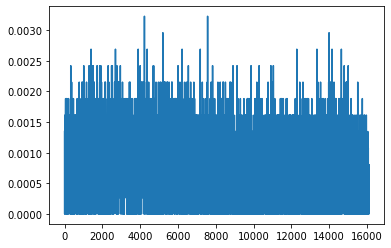

In [87]:
def getHighLowRecallFromRipples(ripples_per_list,sub_list_recall_num_array):
    
    # take list of ripples per trial and output list of correct recall number for high and low ripple lists
    median_ripples = np.median(ripples_per_list)
    high_ripple_idxs = findInd(ripples_per_list > median_ripples)
    low_ripple_idxs = findInd(ripples_per_list <= median_ripples)        
    high_ripple = np.mean(np.array(sub_list_recall_num_array)[np.array(high_ripple_idxs)]) # recalls/list for sub's high ripple lists
    low_ripple = np.mean(np.array(sub_list_recall_num_array)[np.array(low_ripple_idxs)]) # same for low ripple lists
    
    return high_ripple,low_ripple

# kept encoding period long enough for 12*(1.6)+11*(1.0)=30.2 s

min_lists = 20

offset = 100 
presentation_time = 1600
offset_sr = offset/sr_factor # offset of when to look at hippocampal data (in samples). E.g. want to look at word presentation from 100:1700 ms.
presentation_sr = presentation_time/sr_factor

full_encoding_start_array = start_array[:,1000:] # remove 2 sec I added before alignment to first word
# full_encoding_start_array = start_array[:,1000:-1500] # old version removed last 3 sec instead of fancier calculation below

print('# of trials: '+str(np.shape(start_array)[0]))
print('Total # of ripples: '+str(sum(start_array)))
print('Length of start_array: '+str(np.round(np.shape(full_encoding_start_array)[1]/1000*2,2)))

sub_recalls_per_list = []

high_ripple_correct = []
low_ripple_correct = []
word_high_ripple_correct = []
word_low_ripple_correct = []
ISI_high_ripple_correct = []
ISI_low_ripple_correct = []

total_ISI_times = []

for sub in np.unique(subject_name_array):
    sub_idxs = [sub in s for s in subject_name_array]
    if sum(sub_idxs) >= min_lists:
        sub_start_array = full_encoding_start_array[sub_idxs]
        sub_subject_name_array = subject_name_array[sub_idxs]
        sub_session_name_array = session_name_array[sub_idxs]
        sub_list_recall_num_array = list_recall_num_array[sub_idxs]
        sub_encoded_word_times = encoded_word_key_array[sub_idxs]
        
        sub_recalls_per_list.append(np.mean(sub_list_recall_num_array)) # record overall recalls/list for sub       

        # this gets you mean values across entirety of retrieval period        
        # 0.875 is average of 0.75-1.0 s and there are 11 ISIs, so this grabs 0:28.824 s (first 2 seconds were removed already above)
        ripples_per_list = np.sum(sub_start_array[:,:int((1600*12/sr_factor)+(875*11/sr_factor))],1)
#         ripples_per_list = np.sum(sub_start_array,1) # old version just cut off last 3 s
    
        high_ripple,low_ripple = getHighLowRecallFromRipples(ripples_per_list,sub_list_recall_num_array)
        high_ripple_correct.append(high_ripple)
        low_ripple_correct.append(low_ripple)
        
        # now want to split up word presentation and ISI periods by ripple rate
        
        word_ripples_per_list = []
        ISI_ripples_per_list = []
        
        for trial_num in range(len(sub_start_array)):
            word_ripple_list = []; 
            ISI_ripple_list = []; 
            ISI_times = [] # accumulating these as a check
            for i_word,word_time in enumerate(sub_encoded_word_times[trial_num]):
                # note that I already removed the 2 sec initial buffer at top
                word_ripple_list.append(sum(sub_start_array[trial_num, int(word_time/sr_factor+offset_sr): 
                                                            int(word_time/sr_factor+presentation_sr+offset_sr)]))
#                 word_times.append( (word_time/sr_factor+presentation_sr+offset_sr) - (word_time/sr_factor+offset_sr) ) # these are always 1600 by definition
                if i_word<len(sub_encoded_word_times[trial_num])-1: # last word doesn't have an ISI afterwards
                    ISI_ripple_list.append(sum(sub_start_array[trial_num, int(word_time/sr_factor+presentation_sr+offset_sr):
                                                               int(sub_encoded_word_times[trial_num][i_word+1]/sr_factor+offset_sr)]))
                    ISI_times.append( (sub_encoded_word_times[trial_num][i_word+1]/sr_factor+offset_sr) - (word_time/sr_factor+presentation_sr+offset_sr) )
            # now you have number of ripples in this trial for the 12 words and 11 ISIs
            word_ripples_per_list.append(sum(word_ripple_list))
            ISI_ripples_per_list.append(sum(ISI_ripple_list))
            total_ISI_times.extend(ISI_times) # ISI times seem to be more like 900 ms than 875 ms...likely some lag
            
        # now have ripple rates for each trial for both words and ISIs
        high_ripple,low_ripple = getHighLowRecallFromRipples(word_ripples_per_list,sub_list_recall_num_array)
        word_high_ripple_correct.append(high_ripple)
        word_low_ripple_correct.append(low_ripple)        
        high_ripple,low_ripple = getHighLowRecallFromRipples(ISI_ripples_per_list,sub_list_recall_num_array)
        ISI_high_ripple_correct.append(high_ripple)
        ISI_low_ripple_correct.append(low_ripple)           
        
        a=1
plot(np.mean(full_encoding_start_array,0))

1-sample t-tests:
Whole encoding: p=0.226, t=-1.24
Word presentations: p=0.275, t=-1.11
ISI: p=0.012, t=-2.7


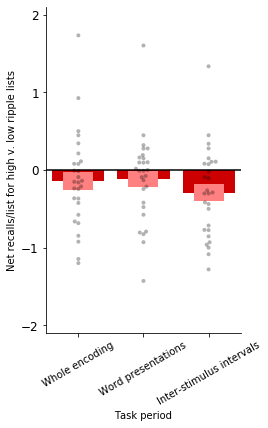

In [88]:
## high v. low recall patients

if location_selected == 'dg':
    min_rate = 0.1
    plot_color = [(0.8,0,0)]
    lmplot_color = (0.8,0,0,0)
    errorbar_color = (1,0.5,0.5)
    line_color = 'darkred'
elif region_name == 'ENT':
    min_rate = 0.0 # for ENT and PHC I don't do further stats so just set to 0 to show all the datapoints in the swarm
    plot_color = [(0.5,0.5,0)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0.8,0.8,0)
    line_color = 'black'
elif region_name == 'PHC':
    min_rate = 0.0
    plot_color = [(0,0.5,0.5)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0,0.8,0.8)
    line_color = 'black' 
elif location_selected == 'ca1' or location_selected == '':
    min_rate = 0.1 # for CA1 and DG I require a FR minimum for the two bins being compared since I do further stats on them
    plot_color = [(0,0,0.8)]
    lmplot_color = (0,0,0.8,0)
    errorbar_color = (0.5,0.5,1)
    line_color = 'darkblue'

high_low_diffs = np.concatenate(( np.array(high_ripple_correct)-np.array(low_ripple_correct),
                                  np.array(word_high_ripple_correct)-np.array(word_low_ripple_correct) ))
high_low_diffs = np.concatenate(( high_low_diffs, np.array(ISI_high_ripple_correct)-np.array(ISI_low_ripple_correct) ))
    
plot_df = pd.DataFrame({'high_low_diffs':high_low_diffs,
                        'idxs':np.concatenate(( np.zeros(len(high_ripple_correct)),np.ones(len(word_high_ripple_correct)), 
                                                2*np.ones(len(ISI_high_ripple_correct)) ))
                        })

mean_correct = [np.mean( np.array(high_ripple_correct)-np.array(low_ripple_correct) ),
                np.mean( np.array(word_high_ripple_correct)-np.array(word_low_ripple_correct) ),
                np.mean( np.array(ISI_high_ripple_correct)-np.array(ISI_low_ripple_correct) )]
ste_correct = [np.std( np.array(high_ripple_correct)-np.array(low_ripple_correct) )/np.sqrt(len(high_ripple_correct)),
                np.std( np.array(word_high_ripple_correct)-np.array(word_low_ripple_correct) )/np.sqrt(len(word_high_ripple_correct)),
                np.std( np.array(ISI_high_ripple_correct)-np.array(ISI_low_ripple_correct) )/np.sqrt(len(ISI_high_ripple_correct))]

figSub,axSub = plt.subplots(1,1, figsize=(3.5,6))
# axSub.bar(range(split_into),mean_ripples,yerr=ste_ripples,color=plot_color)
plot([-1,5],[0,0],color='k')
bar(range(3),mean_correct,yerr=ste_correct,color=plot_color,error_kw=dict(lw=30, capsize=0, capthick=0, ecolor=errorbar_color))

# changes from Mike
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)

extra = '_swarm'
p1 = sb.swarmplot(x='idxs',y='high_low_diffs',data=plot_df, ax=axSub, color=(0,0,0), alpha=0.3, size=4)
axSub.set(ylim=(-2.1,2.1))
ytick_range = np.arange(-2,2.01)
ylabel(u'Net recalls/list for high v. low ripple lists')

    
t_p0 = stats.ttest_1samp(np.array(high_ripple_correct)-np.array(low_ripple_correct),0)
t_p1 = stats.ttest_1samp(np.array(word_high_ripple_correct)-np.array(word_low_ripple_correct),0)
t_p2 = stats.ttest_1samp(np.array(ISI_high_ripple_correct)-np.array(ISI_low_ripple_correct),0)
print('1-sample t-tests:')
print('Whole encoding: p='+str(np.round(t_p0[1],3))+', t='+str(np.round(t_p0[0],2)))    
print('Word presentations: p='+str(np.round(t_p1[1],3))+', t='+str(np.round(t_p1[0],2)))    
print('ISI: p='+str(np.round(t_p2[1],3))+', t='+str(np.round(t_p2[0],2)))    
    
yticks(ytick_range,fontsize=12)
xticks([0,1,2],['Whole encoding','Word presentations','Inter-stimulus intervals'],fontsize=10,rotation=30) # somehow these are reversed but the high patients have high ripples (see the means below)]
xlabel('Task period')

# # check out accuracy rates v. subjects
# print('Whole retrieval period:')
# print(high_low_diffs)
# print(np.unique(subject_name_array))



a=1;

Paired t-test: p=0.226, t=1.24


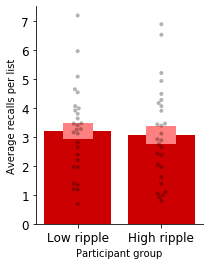

In [89]:
# just the high v. low for whole encoding period

plot_df = pd.DataFrame({'low_high_correct':np.concatenate((low_ripple_correct,high_ripple_correct)),
                        'idxs':np.concatenate((np.zeros(len(low_ripple_correct)),np.ones(len(high_ripple_correct))))
                        })

mean_correct = [np.mean(low_ripple_correct),np.mean(high_ripple_correct)]
ste_correct = [np.std(low_ripple_correct)/np.sqrt(len(low_ripple_correct)),np.std(high_ripple_correct)/np.sqrt(len(high_ripple_correct))]

figSub,axSub = plt.subplots(1,1, figsize=(3,4))
# axSub.bar(range(split_into),mean_ripples,yerr=ste_ripples,color=plot_color)
bar(range(2),mean_correct,yerr=ste_correct,color=plot_color,error_kw=dict(lw=30, capsize=0, capthick=0, ecolor=errorbar_color))

# changes from Mike
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)

add_swarm = 1
if add_swarm == 1:
    extra = '_swarm'
    sb.swarmplot(x='idxs',y='low_high_correct',data=plot_df, ax=axSub, color=(0,0,0), alpha=0.3, size=4)
    axSub.set(ylim=(0,7.5))
    ytick_range = np.arange(0,7.5)
    ylabel(u'Average recalls per list')
else:
    ylim(0,0.175)
    ytick_range = np.arange(0,0.151,0.05)
    extra = ''
    
yticks(ytick_range,fontsize=12)
xticks([1,0],{'Low ripple','High ripple'},fontsize=12) # somehow these are reversed but the high patients have high ripples (see the means below)]
xlabel('Participant group')

# check out accuracy rates v. subjects
# print('Low ripples:')
# print(np.array(low_ripple_correct))
# print('High ripples:')
# print(np.array(high_ripple_correct))
# print(np.unique(subject_name_array))

t_p = stats.ttest_rel(low_ripple_correct,high_ripple_correct)
print('Paired t-test: p='+str(np.round(t_p[1],3))+', t='+str(np.round(t_p[0],2)))
a=1;

## Do the same thing for whole_retrieval out of curiosity

Length of start_array: 32.0
1-sample t-tests:
Whole retrieval: p=0.834, t=-0.21


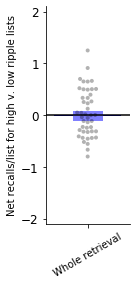

In [149]:
# kept encoding period long enough for 12*(1.6)+11*(1.0)=30.2 s

min_lists = 20

# offset = 100 
# presentation_time = 1600
# offset_sr = offset/sr_factor # offset of when to look at hippocampal data (in samples). E.g. want to look at word presentation from 100:1700 ms.
# presentation_sr = presentation_time/sr_factor

full_retrieval_start_array = start_array[:,1000:16000] # remove 2 sec I added to beginning and end of retrieval
print('Length of start_array: '+str(np.round(np.shape(full_encoding_start_array)[1]/1000*2,2)))

sub_recalls_per_list = []

high_ripple_correct = []
low_ripple_correct = []

for sub in np.unique(subject_name_array):
    sub_idxs = [sub in s for s in subject_name_array]
    if sum(sub_idxs) >= min_lists:
        sub_start_array = full_retrieval_start_array[sub_idxs]
        sub_subject_name_array = subject_name_array[sub_idxs]
        sub_session_name_array = session_name_array[sub_idxs]
        sub_list_recall_num_array = list_recall_num_array[sub_idxs]
        
        sub_recalls_per_list.append(np.mean(sub_list_recall_num_array)) # record overall recalls/list for sub       

        # this gets you mean values across entirety of retrieval period        
        # 0.875 is average of 0.75-1.0 s and there are 11 ISIs, so this grabs 2.0:30.825 s (first 2 seconds were added for plots)
        ripples_per_list = np.sum(sub_start_array,1)
        
        high_ripple,low_ripple = getHighLowRecallFromRipples(ripples_per_list,sub_list_recall_num_array)
        high_ripple_correct.append(high_ripple)
        low_ripple_correct.append(low_ripple)      
           

## high v. low recall patients

if location_selected == 'dg':
    min_rate = 0.1
    plot_color = [(0.8,0,0)]
    lmplot_color = (0.8,0,0,0)
    errorbar_color = (1,0.5,0.5)
    line_color = 'darkred'
elif region_name == 'ENT':
    min_rate = 0.0 # for ENT and PHC I don't do further stats so just set to 0 to show all the datapoints in the swarm
    plot_color = [(0.5,0.5,0)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0.8,0.8,0)
    line_color = 'black'
elif region_name == 'PHC':
    min_rate = 0.0
    plot_color = [(0,0.5,0.5)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0,0.8,0.8)
    line_color = 'black' 
elif location_selected == 'ca1' or location_selected == '':
    min_rate = 0.1 # for CA1 and DG I require a FR minimum for the two bins being compared since I do further stats on them
    plot_color = [(0,0,0.8)]
    lmplot_color = (0,0,0.8,0)
    errorbar_color = (0.5,0.5,1)
    line_color = 'darkblue'

mean_correct = np.mean( np.array(high_ripple_correct)-np.array(low_ripple_correct) )
ste_correct = np.std( np.array(high_ripple_correct)-np.array(low_ripple_correct) )/np.sqrt(len(high_ripple_correct))
plot_df = pd.DataFrame({'high_low_diffs':np.array(high_ripple_correct)-np.array(low_ripple_correct),'idxs':np.zeros(len(high_ripple_correct))})

figSub,axSub = plt.subplots(1,1, figsize=(1.5,4))
# axSub.bar(range(split_into),mean_ripples,yerr=ste_ripples,color=plot_color)
plot([-1,5],[0,0],color='k')
bar(range(3),mean_correct,yerr=ste_correct,color=plot_color,error_kw=dict(lw=30, capsize=0, capthick=0, ecolor=errorbar_color))

# changes from Mike
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)

extra = '_swarm'
p1 = sb.swarmplot(x='idxs',y='high_low_diffs',data=plot_df, ax=axSub, color=(0,0,0), alpha=0.3, size=4)
axSub.set(ylim=(-2.1,2.1))
ytick_range = np.arange(-2,2.01)
ylabel(u'Net recalls/list for high v. low ripple lists')

    
t_p0 = stats.ttest_1samp(np.array(high_ripple_correct)-np.array(low_ripple_correct),0)

print('1-sample t-tests:')
print('Whole retrieval: p='+str(np.round(t_p0[1],3))+', t='+str(np.round(t_p0[0],2)))    
    
yticks(ytick_range,fontsize=12)
xticks([0],['Whole retrieval'],fontsize=10,rotation=30)
xlabel('')

a=1;

## Big Raster!!

(35040, 1500)


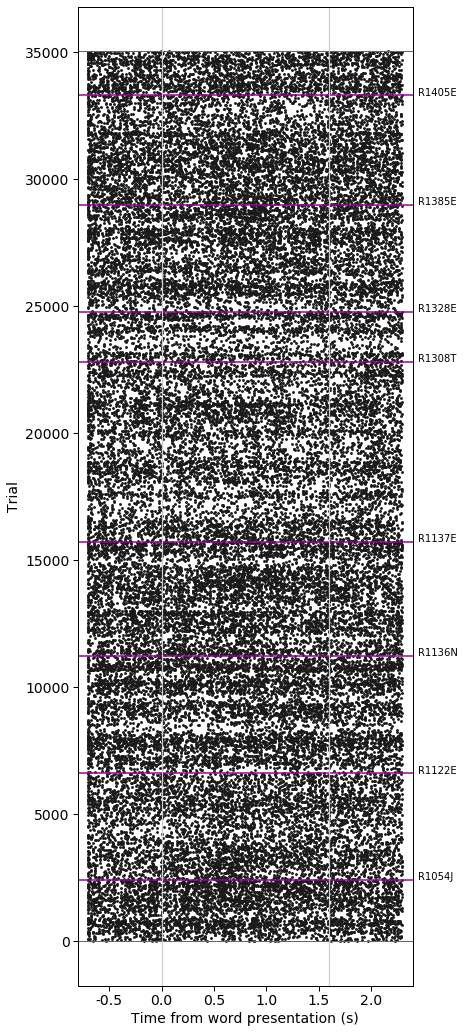

In [164]:

## for the raster and PSTH binarize the data by using the start indices of the ripple

save_raster = 0

%autoreload

elec_dividers_on = 0 # toggles gray lines between electrodes
session_dividers_on = 0 # toggles cyan lines between sessions

dot_color = (0.1,0.1,0.1)
between_subject_color = (0.6,0,0.6) # purple
between_session_color = (0,0.6,0.6) # cyan

# encoding_whole_time = 1000*np.round(12*(1.6+0.875),1)

if selected_period == 'encoding':
    psth_start = -700
    psth_end = 2300
elif selected_period == 'whole_encoding':
    psth_start = -2000
    psth_end = encoding_whole_time #2000
    
raster_width = 6
raster_height = 18 #0 #10 # 40

# plot raster
subplots(1,1,figsize=(raster_width,raster_height))   #y=100 for data cleaning # (4,6) for Fig. 4b # (4,10) for Fig. 2a
scatter(np.where(start_array)[1]*sr_factor+psth_start,np.where(start_array)[0],s=4,color=dot_color) # SWR time v. trial
# xticks(np.arange(psth_start,psth_end+1,500),np.round(np.arange(psth_start/1000,psth_end/1000+1,0.5),2))
xticks(np.arange(-500,2001,500),np.arange(-0.5,2.01,0.5),size=14)
yticks(size=14)
xlabel('Time from word presentation (s)',size=14)
ylabel('Trial')
ax = plt.gca()
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]], linewidth=1,linestyle='-',color=(0,0,0))

last_sub = sub_names[0]
last_sess = sub_sess_names[0]
channels_per_session = []
trial_accum = 0
for s in range(1,len(trial_nums)):
    if (sub_names[s] != last_sub) | (s==1):
        if s != 1:
            # plot dark gray line between subjects
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=1.5,linestyle='-',color=between_subject_color)
            last_sub = sub_names[s]
            text(psth_end+150,0.5+np.sum(trial_nums[:s]),sub_names[s])
        else: 
            if session_dividers_on==1:
                # if 1st sub though gotta print that first gray line 
                plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=between_session_color)
                text(psth_end+100,0,sub_names[s]) # and print 1st sub name at y=0
    else: # plot lines between electrodes
        if elec_dividers_on == 1:
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=(.8,.8,.8))
    # plot lines between sessions
    if session_dividers_on==1:
        if sub_sess_names[s] != last_sess:
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.75,linestyle='-',color=between_session_color)
            last_sess = sub_sess_names[s]
            
    channels_per_session.append(np.unique(channel_nums_array[int(trial_accum):int(trial_accum+trial_nums[s])]))
    trial_accum = trial_accum+trial_nums[s]
    
plot([ax.get_xlim()[0],ax.get_xlim()[1]],-.5*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))        
plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums))*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
gca().axvline(0, ls='-',color=(0.8,0.8,0.8))
gca().axvline(1600, ls='-',color=(0.8,0.8,0.8))
ax.autoscale(enable=True, axis='y', tight=True)
# plt.tight_layout()
# print('Total FR events: '+str(total_recalls)) # these were in whole retrieval period so not kept in usual ripple alignment
# print('Kept FR events: '+str(kept_recalls))
print(start_array.shape);
if save_raster == 1:
    if elec_dividers_on == 1:
        plt.savefig('../figures/rasters/'+exp+'_'+'raster_'+region_name+'_'+location_selected+
                    '-'+str(recall_type_switch)+'-'+filter_type+'.pdf',transparent=True)       
    else:
        plt.savefig('../figures/rasters/'+exp+'_'+'raster_'+region_name+'_'+location_selected+
                    '-'+str(recall_type_switch)+'no_elecs-'+filter_type+'.pdf',transparent=True)
a=1;

# SMEs!! (come here after loading 'encoding' and getting start_array)

done making binned start_array with shape:
(1110, 26)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_lin

SEs created!
done making binned start_array with shape:
(4218, 26)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_lin

SEs created!


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


/home1/john/SWR/figures/ENCODING/SWR_catFR1_PHC__0_soz_in_hamming_first_half.p
Test 1 p-value: 0.4719258030967304
Test 2 p-value: 0.6377401914190979
5328 trials


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


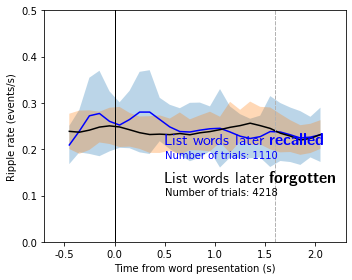

In [45]:
save_plot_data = 0

%autoreload
# get PSTH for recalled and then forgotten words. 
# Then bin it for the CIs and plot each
# then do ME stats on seleted bins and add significance bars if p<0.05

encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700

bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?

desired_sample_rate = 500.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate


if exp == 'RepFR1':
    # *** For RepFR only select your presentation and repeat numbers *** 

    presentation_selection = [2,3] # 1st, 2nd, or 3rd presentation of words? (put in a list like [2] or [2,3])
    repeat_selection = [3] # 1p, 2p, or 3p words? (also in list form)

    selected_idxs = np.intersect1d(findAinB(presentation_selection,presentation_array),
                                   findAinB(repeat_selection,repeat_array))

    start_array = start_array[selected_idxs]
    encoded_word_key_array = encoded_word_key_array[selected_idxs]
    subject_name_array = subject_name_array[selected_idxs]
    session_name_array = session_name_array[selected_idxs]    


# get vectors of encoding list identifier data for forgotten and recalled words
# in encoded_word_key_array, 0 for not recalled, 1 for recalled, 2 for recalled but was an IRI<2 (don't care about that for encoding)

start_array_enc_forgot = start_array[word_correct_array==0]
start_array_enc_recalled = start_array[word_correct_array==1]

# same for sub and sess
sub_forgot = np.array(subject_name_array)[word_correct_array==0]
sess_forgot = np.array(session_name_array)[word_correct_array==0]
sub_recalled = np.array(subject_name_array)[word_correct_array==1]
sess_recalled = np.array(session_name_array)[word_correct_array==1]


# for recalled and then forgotten words
for category in range(2):
    if category == 0:
        temp_start_array = start_array_enc_recalled
        subject_name_array = sub_recalled
        session_name_array = sess_recalled
        
        # for plot
        subplots(1,1,figsize=(5,4))
        label = 'List words later \\textbf{recalled}'
        plot_color = (0,0,1)
        text(500,0.21,label,usetex=True,size=16,color=plot_color)
        text(500,0.18,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)

    else:       
        temp_start_array = start_array_enc_forgot
        subject_name_array = sub_forgot
        session_name_array = sess_forgot
        
        # for plot
        label = 'List words later \\textbf{forgotten}'        
        plot_color = (0,0,0)
        text(500,0.13,label,usetex=True,size=16,color=plot_color) 
        text(500,0.10,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)
        
    # make a PSTH based on start times of SWRs

    PSTH,bin_centers = fullPSTH(temp_start_array,bin_size,smoothing_triangle,sr,pre_encoding_time)

    # get binned start array (trials X bins)
    binned_start_array = binBinaryArray(temp_start_array,bin_size,sr_factor)
    if pad > 0:
        binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
    print('done making binned start_array with shape:')
    print(binned_start_array.shape)

    # note that output is the net ± distance from mean
    SE_plot = getMixedEffectSEs(binned_start_array,subject_name_array,session_name_array)
    print('SEs created!')
    
    # plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    xr = xr[pad:-pad]; 
    
    plot(xr,PSTH[pad:-pad],color=plot_color)
    fill_between(xr, PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)')
    ylabel('Ripple rate (events/s)')
    tight_layout()
    ax = plt.gca()
    ylim = 0.5
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time,encoding_time)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))
    
    if category == 0:
        PSTH_recalled = copy(PSTH)
        SE_recalled = copy(SE_plot)
    else:
        PSTH_forgotten = copy (PSTH)
        SE_forgotten = copy(SE_plot)

# now that we have the plot with CIs, do stats on key bins. Note here just looking at single bins but comparing across categories
for test in range(2):
    if test == 0:
        first_start = 300
        first_end = 1300
    else:
        first_start = 1700 # same idea but for post-encoding period (ILI)
        first_end = 2300 
        
    bin_test_range = range(int( ((first_start-pre_encoding_time)/sr_factor) ),
                           int( ((first_end-pre_encoding_time)/sr_factor) ))
    binned_recalled_array = start_array_enc_recalled[:,bin_test_range]
    binned_forgot_array = start_array_enc_forgot[:,bin_test_range]
    
    stats_bin = int(first_end-first_start)
    binned_recalled_array = binBinaryArray(binned_recalled_array,stats_bin,sr_factor) # should be creating vectors for both
    binned_forgot_array = binBinaryArray(binned_forgot_array,stats_bin,sr_factor)
    
    bin_model = MEstatsAcrossCategories(binned_recalled_array,binned_forgot_array,
                                        sub_forgot,sess_forgot,sub_recalled,sess_recalled)
    
        # plot bands of significance
    if bin_model.pvalues[1] < 0.05:
        plot([first_end-stats_bin,first_end],[0.5,0.5],color=(1,0.5,0))
    
    if test == 0:
        bin_model1 = copy(bin_model)
        binned_recalled_array1 = copy(binned_recalled_array)
        binned_forgot_array1 = copy(binned_forgot_array)
    else:
        bin_model2 = copy(bin_model)
        binned_recalled_array2 = copy(binned_recalled_array)
        binned_forgot_array2 = copy(binned_forgot_array)
num_trials = len(word_correct_array) 


# get directories for if you save (don't put this in save_plot_data below since want p-values printed at bottom close to figures)
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
path_name = '/home1/john/SWR/figures/'+subfolder

fn = os.path.join(path_name,
    'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                  '_'+filter_type+'_'+sub_selection+'.p') # -GT_5000.p' # -LT_5000.p' #'-intrusions.p'
print(fn)
print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
print('Test 2 p-value: '+str(bin_model2.pvalues[1]))
print(str(num_trials)+' trials')    
        
if save_plot_data == 1:
    # get strings for path name for save and loading cluster data
            
    if os.path.isdir(path_name) == False:
        os.mkdir(path_name)
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    with open(fn,'wb') as f:
        pickle.dump({'bin_centers':bin_centers,'PSTH_recalled':PSTH_recalled,'PSTH_forgotten':PSTH_forgotten,
                    'SE_recalled':SE_recalled,'SE_forgotten':SE_forgotten,'bin_model1':bin_model1,'bin_model2':bin_model2,
                    'binned_recalled_array1':binned_recalled_array1,'binned_forgot_array1':binned_forgot_array1,
                    'binned_recalled_array2':binned_recalled_array2,'binned_forgot_array2':binned_forgot_array2,
                    'subject_name_array':subject_name_array,'session_name_array':session_name_array,
                    'electrode_array':electrode_array,'channel_coords_array':channel_coords_array,
                    'word_correct_array':word_correct_array}, f) 
        # word_correct_array is indicator for subsequently remembered and forgotten. Can get num_trials from it too
a=1;

## just to remake plot

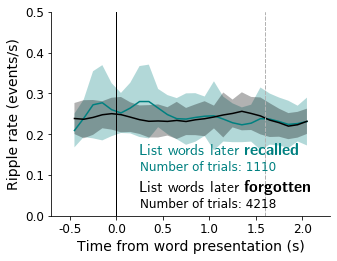

In [46]:
subplots(1,1,figsize=(5,3.75))

# for recalled and then forgotten words
for category in range(2):
    if category == 0:
        temp_start_array = start_array_enc_recalled
        subject_name_array = sub_recalled
        session_name_array = sess_recalled
        
        # for plot
        label = 'List words later \\textbf{recalled}'
        if location_selected == 'ca1':
            plot_color = (0,0,1)
            ytextshift = 0
        elif location_selected == 'dg':
            plot_color = (1,0,0)
            ytextshift = 0
        elif region_name == 'ENT':
            plot_color = (0.5,0.5,0)
            ytextshift = -0.3
        elif region_name == 'PHC':
            plot_color = (0,0.5,0.5)
            ytextshift = 0.05
        text(250,0.2-ytextshift,label,usetex=True,size=16,color=plot_color)
        text(250,0.16-ytextshift,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color,size=12)
        
        PSTH = copy(PSTH_recalled)
        SE_plot = copy(SE_recalled)

    else:       
        temp_start_array = start_array_enc_forgot
        subject_name_array = sub_forgot
        session_name_array = sess_forgot
        
        # for plot
        label = 'List words later \\textbf{forgotten}'        
        plot_color = (0,0,0)
        text(250,0.11-ytextshift,label,usetex=True,size=16,color=plot_color) 
        text(250,0.07-ytextshift,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color,size=12)
        
        PSTH = copy(PSTH_forgotten)
        SE_plot = copy(SE_forgotten)
        
    # plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    xr = xr[pad:-pad]; 
    PSTH = PSTH; #boot_SD = boot_SD[pad:-pad]
    plot(xr,PSTH[pad:-pad],color=plot_color)
    fill_between(xr, PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], facecolor=plot_color, alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)',fontsize=14)
    ylabel('Ripple rate (events/s)',fontsize=14)
#     tight_layout()
    ax = plt.gca()
    ylim = 0.5
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time,encoding_time)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))

xticks(fontsize=12)
yticks(fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)    
a=1;


## encoding ripples by serial position

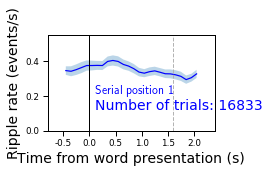

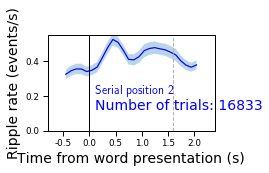

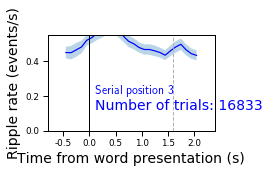

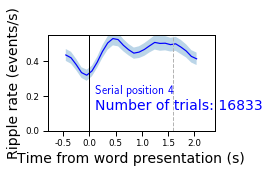

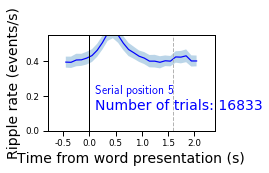

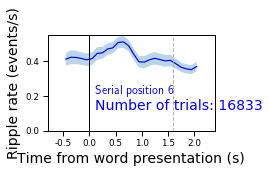

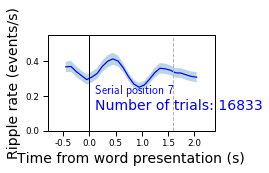

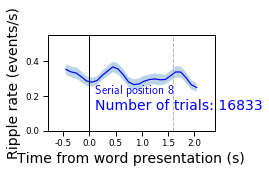

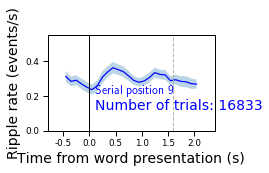

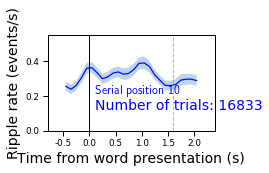

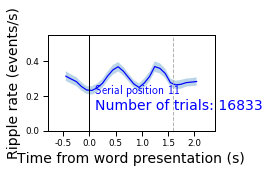

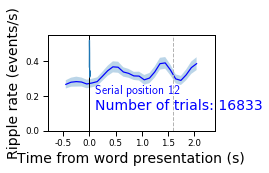

In [120]:
## plot recalled events by serial position

bin_range_to_compare = range(10,20) # range(8,18) is 100:1100 ms # use 300:1300 instead
# bin_range_to_compare = range(24,29) # this is 1700:2200 ms

binsize = 100 # in ms
samples = 100

ct = 0
serial_position_rem_rates = []
serial_position_rem_stds = []
position_rem_stds = []
serial_position_forgot_rates = []
serial_position_forgot_stds = []
tion_forgot_stds = []
num_recalled = []; num_forgot = []
for list_num in range(12):
    
    temp_start_array_rem = start_array[(word_correct_array==1) & (serialpos_array==(list_num+1))]
    temp_start_array_forgot = start_array[(word_correct_array==0) & (serialpos_array==(list_num+1))]
    
    subplots(1,1,figsize=(3,1.75))
    label = 'Serial position '+str(list_num+1)
    plot_color = (0,0,1)
    text(100,0.21,label,usetex=True,size=12,color=plot_color)
    text(100,0.12,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)
    ct+=temp_start_array.shape[0]    
    # make a PSTH based on start times of SWRs

    PSTH,bin_centers = fullPSTH(temp_start_array_rem,binsize,smoothing_triangle,sr,pre_encoding_time)
    PSTH_forgot,bin_centers = fullPSTH(temp_start_array_forgot,binsize,smoothing_triangle,sr,pre_encoding_time)
    
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
    boot_samples = bootstrap(temp_start_array_rem, bootnum=samples, samples=None, # bootstrap error bars using resampling
                   bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,pre_encoding_time))
    boot_SD = np.std(boot_samples,0)
    
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    
    # plot
    plot(xr[pad:-pad],PSTH[pad:-pad],color=plot_color)
    fill_between(xr[pad:-pad], (PSTH+boot_SD)[pad:-pad], (PSTH-boot_SD)[pad:-pad], alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)')
    ylabel('Ripple rate (events/s)')
    ax = plt.gca()
    ylim = 0.55
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time-100,encoding_time+100)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0));
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7));
#     plot([ax.get_xlim()[0],ax.get_xlim()[1]],[0.4,0.4],linewidth=1,linestyle='--',color=(0.5,0.5,0.5));

    # save data for full serial position plot below
    serial_position_rem_rates.append(np.mean(PSTH[bin_range_to_compare]))
    serial_position_rem_stds.append(np.std(PSTH[bin_range_to_compare]))
    serial_position_forgot_rates.append(np.mean(PSTH_forgot[bin_range_to_compare]))
    serial_position_forgot_stds.append(np.std(PSTH_forgot[bin_range_to_compare]))
    num_recalled.append(temp_start_array_rem.shape[0])
    num_forgot.append(temp_start_array_forgot.shape[0])
plot(serial_position_rem_rates)    
a=1;

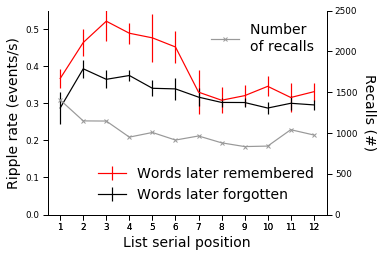

In [122]:
# create the general figure
fig1 = figure(figsize=(5,3.75))
 
# and the first axes using subplot populated with data 
ax1 = fig1.add_subplot(111)

xr=np.arange(1,13)

if location_selected == 'ca1':
    plot_color = (0,0,1)
elif location_selected == 'dg':
    plot_color = (1,0,0)
line1 = errorbar(xr,serial_position_rem_rates,serial_position_rem_stds,color=plot_color) 
line2 = errorbar(xr,serial_position_forgot_rates,serial_position_forgot_stds,color=(0,0,0))
xticks(xr,xr)
ax1.set_ylim(0,ylim)
xlabel('List serial position',size=14)
ylabel('Ripple rate (events/s)',size=14)
# if bin_range_to_compare == range(10,20):
#     title('Ripple rate 300-1300 ms after word presentation')
# elif bin_range_to_compare == range(24,29): 
#     title('Ripple rate 1700-2200 ms after word presentation')
    
# now, the second axes that shares the x-axis with the ax1
ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
line3 = ax2.plot(xr,num_recalled, 'xr-',color=(0.6,0.6,0.6))
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylim(0,2500)
ylabel("Recalls (#)",rotation=270,size=14)
ax2.yaxis.set_label_coords(1.18,0.5)

ax1.legend((line1,line2),("Words later remembered","Words later forgotten"),frameon=False,fontsize=14,loc='lower right')
if (exp == 'catFR1'):
    ax2.legend(line3,{"Number \nof recalls"},loc='upper right',frameon=False,fontsize=14)
else:
    ax2.legend(line3,{"Number of recalls"},loc='upper right',frameon=False,fontsize=14)    
 
# for the legend, remember that we used two different axes so, we need 
# to build the legend manually
# legend((line1, line2), ("1", "2"))
ax1.spines['top'].set_visible(False)   
show();

In [ ]:
num_recalled